# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to ask: “do these datasets have similar patterns”?

To do this we will use [CCA](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.CCA.html) directly, as opposed to using SVCCA which uses the numpy library to compute the individual matrix operations (i.e. dot product, inversions).

**How does CCA work?**
Let A and B be the two datasets we want to compare.  CCA will find a set of basis vectors $(w, v)$ that maximizes the correlation of the two datasets A and B projected onto their respective bases, $corr(w^TA, v^TB)$.  In other words, we want to find the basis vectors (“space”) such that the projection of the data onto their respective basis vectors is highly correlated.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import *
from sklearn.cross_decomposition import CCA
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

simulated_data_file = os.path.join(
    base_dir,
    "data",
    "simulated",
    analysis_name,
    "simulated_data.txt.xz")

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

In [5]:
# Read in data
simulated_data = pd.read_table(
    simulated_data_file,
    header=0, 
    index_col=0,
    sep='\t')

simulated_data.head(10)

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2787,2526,3299,3097,5330,2854,494,5089,3662,1920
0,0.535602,0.503128,0.285015,0.182251,0.338972,0.563961,0.324290,0.469941,0.185681,0.090720,...,0.544562,0.256521,0.326031,0.611043,0.412167,0.438068,0.280573,0.609067,0.402821,0.158164
1,0.602998,0.314449,0.170274,0.150126,0.393875,0.425789,0.359611,0.367097,0.162651,0.060858,...,0.558114,0.284270,0.290870,0.574704,0.281427,0.427374,0.250592,0.675274,0.470036,0.133792
2,0.517498,0.419739,0.182155,0.131460,0.324510,0.413850,0.320531,0.416758,0.152202,0.088437,...,0.792330,0.273688,0.418673,0.734889,0.254353,0.468174,0.249746,0.694683,0.476522,0.128183
3,0.397841,0.457606,0.323778,0.249936,0.297673,0.476715,0.381297,0.468330,0.215541,0.132116,...,0.590046,0.380182,0.329754,0.520238,0.422373,0.406375,0.207356,0.601750,0.407103,0.174844
4,0.535997,0.465947,0.277286,0.222062,0.385123,0.421842,0.330086,0.415129,0.177301,0.128083,...,0.557488,0.298452,0.395627,0.590282,0.290962,0.399933,0.272622,0.597588,0.440435,0.206779
5,0.493290,0.396501,0.249366,0.159639,0.375957,0.402583,0.275842,0.381382,0.261653,0.081041,...,0.688526,0.281114,0.452581,0.688948,0.270457,0.273857,0.142955,0.579213,0.546091,0.433394
6,0.433612,0.351818,0.241003,0.179525,0.336945,0.345377,0.321877,0.382335,0.167349,0.141031,...,0.629592,0.270185,0.363605,0.600325,0.337987,0.378784,0.203119,0.582426,0.467594,0.176376
7,0.451588,0.457565,0.336580,0.272774,0.264118,0.369123,0.275050,0.424156,0.250198,0.247813,...,0.390592,0.251810,0.273909,0.448068,0.424536,0.366531,0.295605,0.435115,0.335833,0.287866
8,0.619654,0.442385,0.281102,0.209915,0.417300,0.559756,0.303963,0.474562,0.233043,0.112126,...,0.427282,0.366223,0.458586,0.647082,0.318879,0.373176,0.295560,0.716585,0.483560,0.206377
9,0.434846,0.361911,0.255196,0.199091,0.345327,0.390971,0.342980,0.392987,0.176265,0.135802,...,0.615511,0.281425,0.373171,0.545738,0.388045,0.386622,0.230204,0.596523,0.427771,0.195655


In [6]:
%%time
# Calculate similarity using CCA
cca = CCA(n_components=10)
output_list = []

for i in num_batches:
    print('Cacluating CCA of 1 batch vs {} batches..'.format(i))
    
    # Get batch 1 data
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Simulated data with all samples in a single batch
    original_data_df =  batch_1
    
    # Get data with additional batch effects added
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    batch_data_df =  batch_other
    
    # CCA
    U_c, V_c = cca.fit_transform(original_data_df, batch_data_df)
    result = np.mean(np.corrcoef(U_c.T, V_c.T)) ## TOP singular value or mean singular value???
    
    output_list.append(result)

Cacluating CCA of 1 batch vs 1 batches..
Cacluating CCA of 1 batch vs 2 batches..
Cacluating CCA of 1 batch vs 5 batches..
Cacluating CCA of 1 batch vs 10 batches..
Cacluating CCA of 1 batch vs 20 batches..
Cacluating CCA of 1 batch vs 50 batches..
Cacluating CCA of 1 batch vs 100 batches..
Cacluating CCA of 1 batch vs 500 batches..
Cacluating CCA of 1 batch vs 1000 batches..
Cacluating CCA of 1 batch vs 2000 batches..
Cacluating CCA of 1 batch vs 3000 batches..
Cacluating CCA of 1 batch vs 6000 batches..
CPU times: user 19h 31min 37s, sys: 2h 6min 57s, total: 21h 38min 34s
Wall time: 5h 16min 37s


In [7]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = simulated_data.shape[0]

for i in range(num_samples):
    row = list(simulated_data.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=simulated_data.index, 
                                       columns=simulated_data.columns)
shuffled_simulated_data.head()

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2787,2526,3299,3097,5330,2854,494,5089,3662,1920
0,0.175321,0.360424,0.418089,0.230013,0.274926,0.333862,0.337634,0.256573,0.349712,0.296682,...,0.238987,0.281721,0.364229,0.305012,0.350766,0.298299,0.391164,0.499064,0.339990,0.386969
1,0.243397,0.185188,0.388284,0.215350,0.284385,0.506368,0.571418,0.597108,0.461700,0.232611,...,0.650626,0.317040,0.146719,0.372988,0.185818,0.455235,0.185335,0.243372,0.527509,0.217176
2,0.621803,0.244584,0.491124,0.139046,0.139101,0.698167,0.122119,0.247636,0.461025,0.314215,...,0.422285,0.217867,0.641419,0.304580,0.402841,0.166918,0.824877,0.591055,0.479896,0.093464
3,0.412054,0.225414,0.462566,0.259026,0.269412,0.407852,0.367866,0.302534,0.263758,0.516463,...,0.293151,0.404198,0.641205,0.213997,0.379692,0.280653,0.387416,0.317822,0.334550,0.179371
4,0.343509,0.175447,0.418351,0.178394,0.192412,0.317310,0.306470,0.413051,0.503342,0.410790,...,0.487166,0.833996,0.386501,0.467030,0.225376,0.607202,0.506643,0.320149,0.507645,0.571042


In [8]:
# CCA of permuted dataset (Negative control)
U_c, V_c = cca.fit_transform(original_data_df, shuffled_simulated_data)
permuted_corrcoef = np.mean(np.corrcoef(U_c.T, V_c.T))

threshold = pd.DataFrame(
    pd.np.tile(
        permuted_corrcoef,
        (len(num_batches), 1)),
    index=num_batches,
    columns=['cca_score'])

permuted_corrcoef

0.09999999893181698

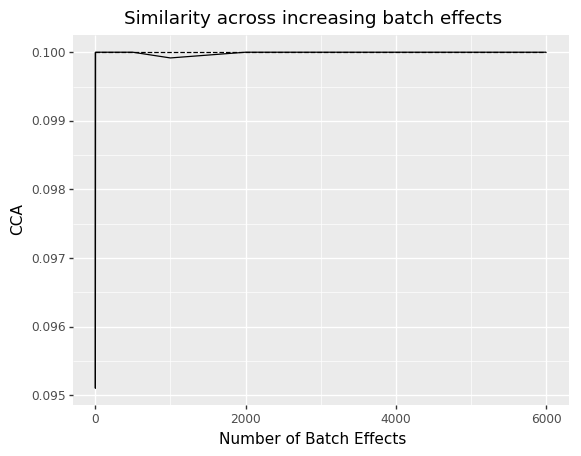

<ggplot: (8789231450786)>

In [9]:
# Plot
cca_per_batch_effect = pd.DataFrame({'num_batch_effects':num_batches, 
                                     'cca_score': output_list
                                    })

ggplot(cca_per_batch_effect, aes(x='num_batch_effects', y='cca_score')) \
    + geom_line() \
    + geom_line(aes(x=num_batches, y='cca_score'), threshold, linetype='dashed') \
    + xlab('Number of Batch Effects') \
    + ylab('CCA') \
    + ggtitle('Similarity across increasing batch effects')

In [10]:
# Print cca scores
cca_per_batch_effect = pd.DataFrame(data={'cca_score': output_list},
                                    index=num_batches)
cca_per_batch_effect

,cca_score
1,0.100000
2,0.095103
5,0.100000
10,0.100000
20,0.100000
50,0.100000
100,0.100000
500,0.100000
1000,0.099917
2000,0.100000
